In [1]:
!pip install rdkit-pypi rdkit torch transformers pytorch-lightning requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing ins

In [2]:
import os
import sys
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import AutoTokenizer, AutoModel
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import AllChem
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import logging
import psutil
import random
from typing import Dict, Optional, List, Any

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True
)
logger = logging.getLogger(__name__)
logger.info("Logging initialized")

# Reproducibility
def seed_everything(seed: int = 42) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything()

# Memory logging
def log_memory_usage() -> None:
    process = psutil.Process()
    mem_info = process.memory_info()
    logger.info(f"Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# SMILES canonicalization
def canonicalize_smiles(smiles: str) -> Optional[str]:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return Chem.MolToSmiles(mol, canonical=True)
    except Exception as e:
        logger.error(f"SMILES canonicalization failed: {e}")
        return None

# Fuzzy SMILES matching
def fuzzy_smiles_match(smiles1: str, smiles2: str, threshold: float = 0.7) -> bool:
    try:
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        if mol1 is None or mol2 is None:
            return False
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, 2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, 2048)
        return DataStructs.TanimotoSimilarity(fp1, fp2) >= threshold
    except:
        return False

# Load BindingDB
def load_bindingdb(path: str, max_samples: int = 20000, chunksize: int = 100000) -> Optional[pd.DataFrame]:
    logger.info(f"Loading BindingDB from {path}")
    try:
        required_cols = ["Ligand SMILES", "Kd (nM)", "BindingDB Target Chain Sequence"]
        df_chunk = pd.read_csv(path, sep="\t", low_memory=False, nrows=10)
        if not all(col in df_chunk.columns for col in required_cols):
            logger.error(f"Missing columns: {set(required_cols) - set(df_chunk.columns)}")
            return None
        
        chunks = []
        total_rows = 0
        invalid_smiles = 0
        for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
            total_rows += len(chunk)
            chunk = chunk.dropna()
            chunk["SMILES"] = chunk["Ligand SMILES"].apply(canonicalize_smiles)
            invalid_smiles += len(chunk) - chunk["SMILES"].notna().sum()
            chunk = chunk[chunk["SMILES"].notna()]
            chunk["Kd (nM)"] = pd.to_numeric(chunk["Kd (nM)"], errors="coerce")
            chunk = chunk.dropna(subset=["Kd (nM)"])
            chunk = chunk[chunk["Kd (nM)"].between(0.1, 1e6)]
            chunks.append(chunk)
            if len(pd.concat(chunks)) >= max_samples:
                break
        
        if not chunks:
            logger.error("No valid BindingDB data")
            return None
        
        df = pd.concat(chunks).head(max_samples)
        df["log_kd"] = -np.log10(df["Kd (nM)"] / 1e9)
        df = df[df["log_kd"].between(-10, 10)]
        df = df.rename(columns={"BindingDB Target Chain Sequence": "Target Sequence"})
        df = df.drop_duplicates(subset=["SMILES"])
        
        logger.info(f"Loaded BindingDB dataset with {len(df)} samples")
        logger.info(f"NaNs in log_kd: {df['log_kd'].isna().sum()}")
        logger.info(f"Total rows processed: {total_rows}, Invalid SMILES: {invalid_smiles} ({invalid_smiles/total_rows*100:.2f}%)")
        logger.info(f"BindingDB log_kd mean: {df['log_kd'].mean():.2f}, std: {df['log_kd'].std():.2f}")
        log_memory_usage()
        return df[["SMILES", "Target Sequence", "log_kd"]]
    except Exception as e:
        logger.error(f"Error loading BindingDB: {e}")
        return None

# Load PubChem AID 1379
def load_pubchem_malaria(path: str, max_compounds: int = 500) -> Optional[pd.DataFrame]:
    logger.info(f"Loading PubChem AID 1379 from {path}")
    try:
        required_cols = ["PUBCHEM_CID", "PUBCHEM_ACTIVITY_OUTCOME", "PUBCHEM_EXT_DATASOURCE_SMILES"]
        df_chunk = pd.read_csv(path, low_memory=False, nrows=10)
        if not all(col in df_chunk.columns for col in required_cols):
            logger.error(f"Missing columns: {set(required_cols) - set(df_chunk.columns)}")
            return None
        
        chunks = []
        total_rows = 0
        invalid_smiles = 0
        for chunk in pd.read_csv(path, usecols=required_cols, chunksize=50000):
            total_rows += len(chunk)
            chunk = chunk.dropna(subset=required_cols)
            chunk = chunk[chunk["PUBCHEM_ACTIVITY_OUTCOME"] == "Active"]
            chunks.append(chunk)
            if len(pd.concat(chunks)) >= max_compounds:
                break
        
        if not chunks:
            logger.error("No active compounds")
            return None
        
        df = pd.concat(chunks).head(max_compounds)
        df["SMILES"] = df["PUBCHEM_EXT_DATASOURCE_SMILES"].apply(canonicalize_smiles)
        invalid_smiles = len(df) - df["SMILES"].notna().sum()
        df = df[df["SMILES"].notna()]
        
        pf_sequences = {
            "PfDHFR": "MKNLLFVLISILCFFSFSDVNDTKVNSTIYENAKKGILDSKNNCNSIIVKNKNDHLDAYKIFDDKFSILSFDIKYNDYLNKKEKNLFFNITYETQEKCSKAFKFFADITNNKWEKIKEFEGTKLKPYLEFFEKTNIIVGNSDRPGMNIMIIKKNDDNNINVVGNSKYILPKHYYKILSGKEADKFSHFNYIFDIKNEKLTNVIVMGRVNWDSKKNSKILNVVRDIILRTIENNKYECFLSISNNSKYTKLLYNNETVSLNDFTKIEKQKDNK",
            "PfPlasmepsin II": "SSNDNIELVDFQNIMFYGDAEVGDNQQPFTFILDTGSANLWVPSAQCTTSPADKKSFIKSNYEFIEKYNLGFKDSIVTYEKGKTYEKLSEGFSISYSDILRGIQKINFDGSSYGMMVGGSDTKYKVELNEILNTIKNSLNILKPKKDVYFMKLIQSVDFPNNIVLDGVDTKSFMNVVNTKYSFGCSGAYTLSLSDNYKNFNYFLDKNIILKAPNFKILNN"
        }
        df["Target Sequence"] = np.random.choice(list(pf_sequences.values()), size=len(df))
        df["log_kd"] = -7.0
        
        bindingdb_path = "/kaggle/input/bindingdb/BindingDB_All.tsv"
        if os.path.exists(bindingdb_path):
            bindingdb = load_bindingdb(bindingdb_path, max_samples=20000)
            if bindingdb is not None:
                initial_rows = len(df)
                df = df.merge(bindingdb[["SMILES", "log_kd"]], on="SMILES", how="left", suffixes=("", "_bindingdb"))
                df["log_kd"] = df["log_kd_bindingdb"].combine_first(df["log_kd"])
                matched_rows = initial_rows - df["log_kd"].eq(-7.0).sum()
                for idx, pubchem_smiles in enumerate(df["SMILES"]):
                    if df.iloc[idx]["log_kd"] == -7.0:
                        matches = bindingdb[bindingdb["SMILES"].apply(lambda x: fuzzy_smiles_match(pubchem_smiles, x, threshold=0.7))]
                        if not matches.empty:
                            df.loc[df["SMILES"] == pubchem_smiles, "log_kd"] = matches["log_kd"].mean()
                            matched_rows += 1
                logger.info(f"AID 1379 after merge: {len(df)} rows, matched with BindingDB: matched_rows")
                logger.info(f"SMILES overlap: {len(set(df['SMILES']) & set(bindingdb['SMILES']))}")
                if matched_rows < 10:
                    logger.warning("Low SMILES matches. Using proxy log_kd.")
                    df["log_kd"] = np.random.normal(-7.0, 0.5, size=len(df))
        else:
            logger.warning("BindingDB path missing. Using proxy log_kd.")
            df["log_kd"] = np.random.normal(-7.0, 0.5, size=len(df))
        
        logger.info(f"Loaded AID 1379 dataset with {len(df)} samples")
        logger.info(f"NaNs in log_kd: {df['log_kd'].isna().sum()}")
        logger.info(f"Total actives processed: {total_rows}, Invalid SMILES: {invalid_smiles} ({invalid_smiles/total_rows*100:.2f}%)")
        logger.info(f"AID 1379 log_kd mean: {df['log_kd'].mean():.2f}, std: {df['log_kd'].std():.2f}")
        log_memory_usage()
        return df[["SMILES", "Target Sequence", "log_kd"]]
    except Exception as e:
        logger.error(f"Error loading AID 1379: {e}")
        return None

# Fallback SMILES Tokenizer
class CustomSMILESTokenizer:
    def __init__(self, max_len: int = 128):
        self.vocab = list("CcNnOoSsClBr#=()[]-+1234567890@%\\")
        self.token2id = {t: i + 1 for i, t in enumerate(self.vocab)}
        self.max_len = max_len
    
    def tokenize(self, smiles: str) -> Dict[str, torch.Tensor]:
        tokens = [self.token2id.get(c, 0) for c in smiles if c in self.token2id]
        tokens = tokens[:self.max_len]
        tokens += [0] * (self.max_len - len(tokens))
        attention_mask = [1 if t != 0 else 0 for t in tokens]
        return {
            "input_ids": torch.tensor(tokens, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long)
        }

# SMILES and Protein Tokenizer
class SMILESProteinTokenizer:
    def __init__(self, max_len_smiles: int = 128, max_len_protein: int = 512):
        self.max_len_smiles = max_len_smiles
        self.max_len_protein = max_len_protein
        try:
            logger.info("Loading Hugging Face tokenizers")
            self.smiles_tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
            self.protein_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
            self.use_custom = False
        except Exception as e:
            logger.warning(f"Failed to load SMILES tokenizer: {e}. Using custom.")
            self.smiles_tokenizer = CustomSMILESTokenizer(max_len_smiles)
            self.protein_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
            self.use_custom = True
    
    def tokenize(self, smiles: str, protein: str) -> Optional[Dict[str, torch.Tensor]]:
        try:
            if not isinstance(smiles, str) or not isinstance(protein, str):
                logger.error(f"Invalid input types: SMILES={type(smiles)}, Protein={type(protein)}")
                return None
            if self.use_custom:
                smiles_enc = self.smiles_tokenizer.tokenize(smiles)
            else:
                smiles_enc = self.smiles_tokenizer(
                    smiles, max_length=self.max_len_smiles, padding="max_length", truncation=True, return_tensors="pt"
                )
            protein_enc = self.protein_tokenizer(
                protein, max_length=self.max_len_protein, padding="max_length", truncation=True, return_tensors="pt"
            )
            return {
                "smiles_input_ids": smiles_enc["input_ids"].squeeze(),
                "smiles_attention_mask": smiles_enc["attention_mask"].squeeze(),
                "protein_input_ids": protein_enc["input_ids"].squeeze(),
                "protein_attention_mask": protein_enc["attention_mask"].squeeze()
            }
        except Exception as e:
            logger.error(f"Tokenization error: {e}")
            return None

class DTIDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: SMILESProteinTokenizer, log_kd_mean: float = 0.0, log_kd_std: float = 1.0, is_aid1379: bool = False, randomize_smiles_flag: bool = False):
        self.df = df
        self.tokenizer = tokenizer
        self.log_kd_mean = log_kd_mean
        self.log_kd_std = log_kd_std
        self.is_aid1379 = is_aid1379
        self.failed_samples: List[int] = []
        self.randomize_smiles_flag = randomize_smiles_flag
        logger.info(f"Creating dataset with {len(df)} samples, is_aid1379={is_aid1379}, randomize_smiles={randomize_smiles_flag}")
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Optional[Dict[str, Any]]:
        row = self.df.iloc[idx]
        try:
            smiles, protein, log_kd = row["SMILES"], row["Target Sequence"], row["log_kd"]
            # Randomize SMILES only during training
            if self.randomize_smiles_flag and hasattr(self, 'training') and self.training:
                randomized = randomize_smiles(smiles)
                if randomized is not None:
                    smiles = randomized
            if not isinstance(smiles, str) or not isinstance(protein, str) or not isinstance(log_kd, (int, float)):
                logger.warning(f"Invalid data at idx {idx}: SMILES={type(smiles)}, Protein={type(protein)}, log_kd={type(log_kd)}")
                self.failed_samples.append(idx)
                return None
            if Chem.MolFromSmiles(smiles) is None:
                logger.warning(f"Invalid SMILES at idx {idx}")
                self.failed_samples.append(idx)
                return None
            tokens = self.tokenizer.tokenize(smiles, protein)
            if tokens is None:
                self.failed_samples.append(idx)
                return None
            normalized_log_kd = (log_kd - self.log_kd_mean) / self.log_kd_std
            return {
                **tokens,
                "log_kd": torch.tensor(normalized_log_kd, dtype=torch.float32),
                "original_log_kd": torch.tensor(log_kd, dtype=torch.float32),
                "smiles": smiles,
                "protein": protein,
                "is_aid1379": self.is_aid1379
            }
        except Exception as e:
            logger.error(f"Dataset error at idx {idx}: {e}")
            self.failed_samples.append(idx)
            return None

def collate_fn(batch: List[Optional[Dict]]) -> Optional[Dict[str, Any]]:
    batch = [b for b in batch if b is not None]
    if not batch:
        logger.warning("Empty batch after filtering")
        return None
    return {
        "smiles_input_ids": torch.stack([b["smiles_input_ids"] for b in batch]),
        "smiles_attention_mask": torch.stack([b["smiles_attention_mask"] for b in batch]),
        "protein_input_ids": torch.stack([b["protein_input_ids"] for b in batch]),
        "protein_attention_mask": torch.stack([b["protein_attention_mask"] for b in batch]),
        "log_kd": torch.stack([b["log_kd"] for b in batch]),
        "original_log_kd": torch.stack([b["original_log_kd"] for b in batch]),
        "smiles": [b["smiles"] for b in batch],
        "protein": [b["protein"] for b in batch],
        "is_aid1379": torch.tensor([b["is_aid1379"] for b in batch], dtype=torch.bool)
    }

def create_bindingdb_loader(bindingdb_path: str, tokenizer: SMILESProteinTokenizer, batch_size: int = 16, max_samples: int = 20000) -> tuple:
    logger.info("Creating BindingDB DataLoaders")
    bindingdb_df = load_bindingdb(bindingdb_path, max_samples=max_samples)
    
    if bindingdb_df is None or len(bindingdb_df) == 0:
        logger.warning("Empty BindingDB dataset")
        bindingdb_df = pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"])
    
    train_bindingdb = bindingdb_df.sample(frac=0.8, random_state=42)
    val_bindingdb = bindingdb_df.drop(train_bindingdb.index).sample(frac=0.5, random_state=42)
    test_bindingdb = bindingdb_df.drop(train_bindingdb.index).drop(val_bindingdb.index)
    
    log_kd_mean = train_bindingdb["log_kd"].mean()
    log_kd_std = train_bindingdb["log_kd"].std()
    if log_kd_std == 0:
        log_kd_std = 1.0
    logger.info(f"Normalization parameters - log_kd_mean: {log_kd_mean:.2f}, log_kd_std: {log_kd_std:.2f}")
    
    logger.info(f"BindingDB splits - Train: {len(train_bindingdb)}, Val: {len(val_bindingdb)}, Test: {len(test_bindingdb)}")
    
    train_dataset = DTIDataset(train_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=True)
    val_dataset = DTIDataset(val_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=False)
    test_dataset = DTIDataset(test_bindingdb, tokenizer, log_kd_mean, log_kd_std, is_aid1379=False, randomize_smiles_flag=False)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn) if len(train_dataset) > 0 else None
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(val_dataset) > 0 else None
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(test_dataset) > 0 else None
    
    for dataset, name in [
        (train_dataset, "BindingDB Train"),
        (val_dataset, "BindingDB Val"),
        (test_dataset, "BindingDB Test")
    ]:
        logger.info(f"{name} failed samples: {len(dataset.failed_samples)} / {len(dataset)}")
    
    log_memory_usage()
    return train_loader, val_loader, test_loader, log_kd_mean, log_kd_std

def create_aid1379_loader(pubchem_path: str, tokenizer: SMILESProteinTokenizer, batch_size: int = 16, max_compounds: int = 500, bindingdb_path: str = None) -> tuple:
    logger.info("Creating AID 1379 DataLoaders")
    pubchem_df = load_pubchem_malaria(pubchem_path, max_compounds=max_compounds)
    
    if pubchem_df is None or len(pubchem_df) == 0:
        logger.error("Empty AID 1379 dataset")
        return None, None, None
    
    train_pubchem = pubchem_df.sample(frac=0.8, random_state=42)
    val_pubchem = pubchem_df.drop(train_pubchem.index).sample(frac=0.5, random_state=42)
    test_pubchem = pubchem_df.drop(train_pubchem.index).drop(val_pubchem.index)
    
    # Use BindingDB's normalization parameters if available
    if bindingdb_path and os.path.exists(bindingdb_path):
        bindingdb_df = load_bindingdb(bindingdb_path, max_samples=20000)
        if bindingdb_df is not None:
            log_kd_mean = bindingdb_df["log_kd"].mean()
            log_kd_std = bindingdb_df["log_kd"].std()
        else:
            log_kd_mean = train_pubchem["log_kd"].mean()
            log_kd_std = train_pubchem["log_kd"].std()
    else:
        log_kd_mean = train_pubchem["log_kd"].mean()
        log_kd_std = train_pubchem["log_kd"].std()
    
    if log_kd_std == 0:
        log_kd_std = 1.0
    logger.info(f"AID 1379 normalization - log_kd_mean: {log_kd_mean:.2f}, log_kd_std: {log_kd_std:.2f}")
    
    logger.info(f"AID 1379 splits - Train: {len(train_pubchem)}, Val: {len(val_pubchem)}, Test: {len(test_pubchem)}")
    
    malaria_train_dataset = DTIDataset(train_pubchem, tokenizer, log_kd_mean, log_kd_std, is_aid1379=True, randomize_smiles_flag=True)
    malaria_val_dataset = DTIDataset(val_pubchem, tokenizer, log_kd_mean, log_kd_std, is_aid1379=True, randomize_smiles_flag=False)
    malaria_test_dataset = DTIDataset(test_pubchem, tokenizer, log_kd_mean, log_kd_std, is_aid1379=True, randomize_smiles_flag=False)
    
    malaria_train_loader = DataLoader(malaria_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn) if len(malaria_train_dataset) > 0 else None
    malaria_val_loader = DataLoader(malaria_val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(malaria_val_dataset) > 0 else None
    malaria_test_loader = DataLoader(malaria_test_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn) if len(malaria_test_dataset) > 0 else None
    
    for dataset, name in [
        (malaria_train_dataset, "AID 1379 Train"),
        (malaria_val_dataset, "AID 1379 Val"),
        (malaria_test_dataset, "AID 1379 Test")
    ]:
        logger.info(f"{name} failed samples: {len(dataset.failed_samples)} / {len(dataset)}")
    
    log_memory_usage()
    return malaria_train_loader, malaria_val_loader, malaria_test_loader

def create_dataloaders(bindingdb_path: str, pubchem_path: str, batch_size: int = 16) -> tuple:
    logger.info("Creating DataLoaders")
    tokenizer = SMILESProteinTokenizer()
    
    # Create BindingDB loaders
    bindingdb_loaders = create_bindingdb_loader(bindingdb_path, tokenizer, batch_size)
    if bindingdb_loaders is None:
        logger.error("Failed to create BindingDB loaders")
        return None, None, None, None, None, None, 0.0, 1.0
    train_loader, val_loader, test_loader, log_kd_mean, log_kd_std = bindingdb_loaders
    
    # Create AID 1379 loaders
    malaria_loaders = create_aid1379_loader(pubchem_path, tokenizer, batch_size, bindingdb_path=bindingdb_path)
    if malaria_loaders is None:
        logger.error("Failed to create AID 1379 loaders")
        return None, None, None, None, None, None, log_kd_mean, log_kd_std
    malaria_train_loader, malaria_val_loader, malaria_test_loader = malaria_loaders
    
    # Create fine-tuning datasets
    train_bindingdb = train_loader.dataset.df if train_loader else pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"])
    finetune_train_dataset = ConcatDataset([
        DTIDataset(
            train_bindingdb.sample(n=min(4000, len(train_bindingdb)), random_state=42),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ) if len(train_bindingdb) > 0 else DTIDataset(
            pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"]),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ),
        malaria_train_loader.dataset
    ])
    finetune_val_dataset = ConcatDataset([
        val_loader.dataset if val_loader else DTIDataset(
            pd.DataFrame(columns=["SMILES", "Target Sequence", "log_kd"]),
            tokenizer,
            log_kd_mean,
            log_kd_std,
            is_aid1379=False
        ),
        malaria_val_loader.dataset
    ])
    
    finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
    finetune_val_loader = DataLoader(finetune_val_dataset, batch_size=batch_size, num_workers=2, collate_fn=collate_fn)
    
    return (
        train_loader,
        val_loader,
        test_loader,
        finetune_train_loader,
        finetune_val_loader,
        malaria_test_loader,
        log_kd_mean,
        log_kd_std
    )


class CrossAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int = 8):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, key_padding_mask: torch.Tensor = None) -> torch.Tensor:
        if key_padding_mask is not None:
            key_padding_mask = ~key_padding_mask.bool()
        attn_output, _ = self.multihead_attn(query, key, value, key_padding_mask=key_padding_mask)
        return attn_output
    
# Define correlation_loss
def correlation_loss(pred, target):
    pred = pred.float()
    target = target.float()
    pred_mean = pred.mean()
    target_mean = target.mean()
    pred_centered = pred - pred_mean
    target_centered = target - target_mean
    numerator = (pred_centered * target_centered).sum()
    denominator = torch.sqrt((pred_centered ** 2).sum() * (target_centered ** 2).sum()) + 1e-8
    corr = numerator / denominator
    return 1 - corr
        
class DTIModel(pl.LightningModule):
    def __init__(self, smiles_model_name: str = "seyonec/PubChem10M_SMILES_BPE_450k", protein_model_name: str = "facebook/esm2_t12_35M_UR50D", hidden_dim: int = 256, learning_rate: float = 1e-5, log_kd_mean: float = 0.0, log_kd_std: float = 1.0):
        super().__init__()
        self.save_hyperparameters()
        self.smiles_encoder = AutoModel.from_pretrained(smiles_model_name)
        self.protein_encoder = AutoModel.from_pretrained(protein_model_name)
        self.smiles_dim = self.smiles_encoder.config.hidden_size
        self.protein_dim = self.protein_encoder.config.hidden_size
        self.protein_preproj = nn.Linear(self.protein_dim, self.smiles_dim)
        self.cross_attention = CrossAttention(self.smiles_dim, num_heads=8)
        self.smiles_proj = nn.Linear(self.smiles_dim, hidden_dim)
        self.protein_proj = nn.Linear(self.smiles_dim, hidden_dim)
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
        self.criterion = nn.MSELoss()
        self.test_predictions = []
        self.test_targets = []
        self.test_smiles = []
        self.test_proteins = []
        self.dataset_name = "Unknown"
        self.is_finetuning = False
        self.log_kd_mean = log_kd_mean
        self.log_kd_std = log_kd_std
        self.running_mu_p = 0.0
        self.running_sigma_p = 1.0
        self.running_mu_t = 0.0
        self.running_sigma_t = 1.0
        self.momentum = 0.1
        self.min_variance = 0.1

    def forward(self, smiles_input_ids, smiles_attention_mask, protein_input_ids, protein_attention_mask):
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            smiles_embeds = self.smiles_encoder(input_ids=smiles_input_ids, attention_mask=smiles_attention_mask).last_hidden_state
            protein_embeds = self.protein_encoder(input_ids=protein_input_ids, attention_mask=protein_attention_mask).last_hidden_state
            if self.training and self.is_finetuning:
                smiles_embeds = smiles_embeds + 0.01 * torch.randn_like(smiles_embeds)
                protein_embeds = protein_embeds + 0.01 * torch.randn_like(protein_embeds)
            protein_embeds = self.protein_preproj(protein_embeds)
            combined_embeds = self.cross_attention(query=smiles_embeds, key=protein_embeds, value=protein_embeds, key_padding_mask=protein_attention_mask)
            smiles_pooled = combined_embeds.mean(dim=1)
            protein_pooled = protein_embeds.mean(dim=1)
            smiles_pooled = self.smiles_proj(smiles_pooled)
            protein_pooled = self.protein_proj(protein_pooled)
            combined = torch.cat([smiles_pooled, protein_pooled], dim=-1)
            log_kd_pred = self.regression_head(combined).squeeze(-1)
            log_kd_pred = log_kd_pred * self.log_kd_std + self.log_kd_mean
            return log_kd_pred

    def kl_divergence(self, pred: torch.Tensor, target: torch.Tensor, bins: int = 50) -> torch.Tensor:
        """Compute KL divergence between prediction and target distributions."""
        pred = pred.to(torch.float32)
        target = target.to(torch.float32)
        pred_hist = torch.histc(pred, bins=bins, min=-10, max=10)
        target_hist = torch.histc(target, bins=bins, min=-10, max=10)
        pred_hist = pred_hist / (pred_hist.sum() + 1e-10)
        target_hist = target_hist / (target_hist.sum() + 1e-10)
        return torch.sum(target_hist * torch.log((target_hist + 1e-10) / (pred_hist + 1e-10)))

    def training_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in training_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch detected"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        
        is_aid1379 = batch.get("is_aid1379", torch.zeros(batch_size, dtype=torch.bool, device=log_kd_pred.device))
        assert is_aid1379.shape[0] == batch_size, f"is_aid1379 shape mismatch: {is_aid1379.shape[0]} vs {batch_size}"
        
        if (~is_aid1379).any():
            pred_bindingdb = log_kd_pred[~is_aid1379]
            targets_bindingdb = targets[~is_aid1379]
            loss_bindingdb = self.criterion(pred_bindingdb, targets_bindingdb)
            self.log("train_loss_bindingdb", loss_bindingdb, on_step=True, on_epoch=True, batch_size=(~is_aid1379).sum())
        else:
            loss_bindingdb = torch.tensor(0.0, device=log_kd_pred.device)
        
        if is_aid1379.any():
            pred_aid1379 = log_kd_pred[is_aid1379]
            targets_aid1379 = targets[is_aid1379]
            mu_b = pred_aid1379.mean()
            sigma_b = pred_aid1379.std()
            mu_t_b = targets_aid1379.mean()
            sigma_t_b = targets_aid1379.std()
        
            # Skip if invalid or too small
            if torch.isnan(sigma_b) or torch.isnan(sigma_t_b) or sigma_b < 1e-6 or sigma_t_b < 1e-6:
                logger.warning(f"Skipping batch: Invalid or too small std - sigma_b: {sigma_b}, sigma_t_b: {sigma_t_b}")
                return None
        
            # ...rest of your code...
            
            assert sigma_b > 1e-6, f"Prediction variance collapsed: std={sigma_b}"
            assert sigma_t_b > 1e-6, f"Target variance too low: std={sigma_t_b}"
            
            self.running_mu_p = (1 - self.momentum) * self.running_mu_p + self.momentum * mu_b.item()
            self.running_sigma_p = (1 - self.momentum) * self.running_sigma_p + self.momentum * sigma_b.item()
            self.running_mu_t = (1 - self.momentum) * self.running_mu_t + self.momentum * mu_t_b.item()
            self.running_sigma_t = (1 - self.momentum) * self.running_sigma_t + self.momentum * sigma_t_b.item()
            
            # Robust scaling
            scale_factor = sigma_t_b / (sigma_b + 1e-6)
            scale_factor = torch.clamp(scale_factor, min=0.1, max=10.0)  # Prevent extreme scaling
            scaled_pred_aid1379 = mu_t_b + scale_factor * (pred_aid1379 - mu_b)
            
            loss_mse = self.criterion(scaled_pred_aid1379, targets_aid1379)
            kl_loss = self.kl_divergence(scaled_pred_aid1379, targets_aid1379)
            
            if batch_size > 1:
                pred_np = scaled_pred_aid1379.detach().cpu().numpy()
                target_np = targets_aid1379.detach().cpu().numpy()
                spearman_corr, _ = spearmanr(pred_np, target_np)
                spearman_loss = 1 - spearman_corr
                r2 = max(0.0, r2_score(target_np, pred_np)) if np.var(target_np) > 1e-6 else 0.0
                self.log("train_r2_aid1379", r2, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
            else:
                spearman_loss = 0.0
                r2 = 0.0
            
            loss_aid1379 = loss_mse + 1.0 * kl_loss + 1.0 * spearman_loss  # Reduced weights
            self.log("train_loss_aid1379", loss_aid1379, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
            self.log("train_pred_std_aid1379", sigma_b, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
            self.log("train_target_std_aid1379", sigma_t_b, on_step=True, on_epoch=True, batch_size=is_aid1379.sum())
        else:
            loss_aid1379 = torch.tensor(0.0, device=log_kd_pred.device)
        
        # Add correlation loss for all predictions
        corr_loss = correlation_loss(log_kd_pred, targets)
        self.log("train_corr_loss", corr_loss, on_step=True, on_epoch=True, batch_size=batch_size)
        loss = loss_bindingdb + (5.0 * loss_aid1379 if self.is_finetuning else loss_aid1379) + 0.1 * corr_loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in validation_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch in validation_step"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        is_aid1379 = batch.get("is_aid1379", torch.zeros(batch_size, dtype=torch.bool, device=log_kd_pred.device))
        if (~is_aid1379).any():
            pred_bindingdb = log_kd_pred[~is_aid1379]
            targets_bindingdb = targets[~is_aid1379]
            loss_bindingdb = self.criterion(pred_bindingdb, targets_bindingdb)
            self.log("val_loss_bindingdb", loss_bindingdb, on_step=False, on_epoch=True, batch_size=(~is_aid1379).sum())
        else:
            loss_bindingdb = torch.tensor(0.0, device=log_kd_pred.device)
        if is_aid1379.any():
            pred_aid1379 = log_kd_pred[is_aid1379]
            targets_aid1379 = targets[is_aid1379]
            mu_b = pred_aid1379.mean()
            sigma_b = pred_aid1379.std()
            mu_t_b = targets_aid1379.mean()
            sigma_t_b = targets_aid1379.std()
            # Skip if invalid
            if torch.isnan(sigma_b) or torch.isnan(sigma_t_b):
                logger.warning(f"Invalid validation statistics - sigma_b: {sigma_b}, sigma_t_b: {sigma_t_b}")
                return None
            scale_factor = sigma_t_b / (sigma_b + 1e-6)
            scale_factor = torch.clamp(scale_factor, min=0.1, max=10.0)
            scaled_pred_aid1379 = mu_t_b + scale_factor * (pred_aid1379 - mu_b)
            loss_aid1379 = self.criterion(scaled_pred_aid1379, targets_aid1379)
            self.log("val_pred_std_aid1379", sigma_b, on_step=False, on_epoch=True, batch_size=is_aid1379.sum())
            self.log("val_target_std_aid1379", sigma_t_b, on_step=False, on_epoch=True, batch_size=is_aid1379.sum())
        else:
            loss_aid1379 = torch.tensor(0.0, device=log_kd_pred.device)
        # Always compute and log loss here
        loss = loss_bindingdb + (5.0 * loss_aid1379 if self.is_finetuning else loss_aid1379)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def test_step(self, batch, batch_idx):
        if batch is None:
            logger.warning("None batch in test_step")
            return None
        batch_size = batch["smiles_input_ids"].shape[0]
        assert batch_size > 0, "Empty batch in test_step"
        log_kd_pred = self(batch["smiles_input_ids"], batch["smiles_attention_mask"], batch["protein_input_ids"], batch["protein_attention_mask"])
        targets = batch["original_log_kd"]
        # Denormalize predictions for AID1379
        if self.dataset_name == "AID1379":
            log_kd_pred = log_kd_pred * self.log_kd_std + self.log_kd_mean
            logger.info("AID1379 test: Denormalized predictions using mean/std.")
        loss = self.criterion(log_kd_pred, targets)
        self.test_predictions.append(log_kd_pred.cpu())
        self.test_targets.append(targets.cpu())
        self.test_smiles.extend(batch["smiles"])
        self.test_proteins.extend(batch["protein"])
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def on_test_epoch_end(self):
        predictions = torch.cat(self.test_predictions).numpy()
        targets = torch.cat(self.test_targets).numpy()
        assert len(predictions) == len(targets), f"Predictions ({len(predictions)}) and targets ({len(targets)}) length mismatch"
        # Ensure predictions and targets are on the same scale for AID1379
        if self.dataset_name == "AID1379":
            logger.info("AID1379 test: Ensuring predictions and targets are on the same scale for metrics.")
            # (Already denormalized in test_step)
        test_loss = self.criterion(torch.tensor(predictions), torch.tensor(targets)).item()
        test_mae = mean_absolute_error(targets, predictions)
        test_rmse = np.sqrt(mean_squared_error(targets, predictions))
        if len(set(targets)) <= 1:
            test_r2 = np.nan
            logger.warning("Test set has only one unique target value; r2 is undefined.")
        else:
            test_r2 = r2_score(targets, predictions)
        if np.var(targets) > 1e-6 and np.var(predictions) > 1e-6:
            test_pearson, _ = pearsonr(targets, predictions)
        else:
            test_pearson = np.nan
        logger.info(f"Test predictions mean: {predictions.mean():.2f}, std: {predictions.std():.2f}")
        logger.info(f"Test targets mean: {targets.mean():.2f}, std: {targets.std():.2f}")
        logger.info(f"Test metrics: loss={test_loss:.3f}, mae={test_mae:.3f}, rmse={test_rmse:.3f}, r2={test_r2}, pearson={test_pearson}")
        if len(targets) < 10:
            logger.warning(f"Test set is very small (n={len(targets)}); metrics may be unreliable.")
        pd.DataFrame({
            "predictions": predictions,
            "targets": targets,
            "smiles": self.test_smiles,
            "proteins": self.test_proteins
        }).to_csv(f"test_predictions_{self.dataset_name}.csv", index=False)
        self.test_predictions = []
        self.test_targets = []
        self.test_smiles = []
        self.test_proteins = []

    def configure_optimizers(self):
        lr = 1e-5 if not self.is_finetuning else 1e-5
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
            "gradient_clip_val": 1.0  # Add gradient clipping
        }

    def configure_finetuning(self):
        if self.is_finetuning:
            for name, param in self.smiles_encoder.named_parameters():
                param.requires_grad = True
            for name, param in self.protein_encoder.named_parameters():
                param.requires_grad = True
            for param in self.protein_preproj.parameters():
                param.requires_grad = True
            for param in self.cross_attention.parameters():
                param.requires_grad = True
            for param in self.smiles_proj.parameters():
                param.requires_grad = True
            for param in self.protein_proj.parameters():
                param.requires_grad = True
            for param in self.regression_head.parameters():
                param.requires_grad = True


# SMILES randomization
def randomize_smiles(smiles: str, random_type: str = "restricted") -> Optional[str]:
    """Return a randomized SMILES string using RDKit."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        if random_type == "unrestricted":
            return Chem.MolToSmiles(mol, doRandom=True)
        else:
            return Chem.MolToSmiles(mol, doRandom=True, canonical=False)
    except Exception as e:
        logger.error(f"SMILES randomization failed: {e}")
        return None

# Main function
if __name__ == "__main__":
    bindingdb_path = "/kaggle/input/bindingdb/BindingDB_All.tsv"
    pubchem_path = "/kaggle/input/all-pubchem-aid-1379/AID_1379.csv"
    
    if not os.path.exists(bindingdb_path):
        logger.error(f"BindingDB path missing: {bindingdb_path}")
        sys.exit(1)
    if not os.path.exists(pubchem_path):
        logger.error(f"PubChem path missing: {pubchem_path}")
        sys.exit(1)
    
    dataloaders = create_dataloaders(bindingdb_path, pubchem_path)
    if dataloaders is None:
        logger.error("Failed to create dataloaders")
        sys.exit(1)
    train_loader, val_loader, test_loader, finetune_train_loader, finetune_val_loader, malaria_test_loader, log_kd_mean, log_kd_std = dataloaders
    
    if train_loader is not None:
        try:
            for batch in train_loader:
                if batch is None or len(batch) == 0:
                    logger.warning("Empty batch in train_loader")
                    continue
                else:
                    logger.info(f"Sample batch shapes: SMILES input_ids={batch['smiles_input_ids'].shape}, log_kd={batch['log_kd'].shape}")
                break
        except Exception as e:
            logger.error(f"Error testing train_loader: {e}")
    
    model = DTIModel(log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
    logger.info(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    logger.info("Using batch_size=2, learning_rate=1e-5 for pre-training, 1.2e-5 for fine-tuning")
    log_memory_usage()
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="/kaggle/working/checkpoints",
        filename="dti-model-{epoch:02d}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1
    )
    early_stopping = EarlyStopping(monitor="val_loss", patience=7, mode="min")
    callbacks = [checkpoint_callback, early_stopping]
    
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=callbacks,
        logger=pl.loggers.TensorBoardLogger("/kaggle/working/logs", name="dti"),
        precision="16-mixed"
    )
    
    logger.info("Starting BindingDB pre-training")
    if train_loader is not None and val_loader is not None:
        trainer.fit(model, train_loader, val_loader)
        logger.info(f"Best checkpoint: {checkpoint_callback.best_model_path}")
        log_memory_usage()
        torch.cuda.empty_cache()
    
    checkpoint_path = checkpoint_callback.best_model_path
    if checkpoint_path and os.path.isfile(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
        logger.info(f"Testing checkpoint: {checkpoint_path}")
        bindingdb_model = DTIModel.load_from_checkpoint(checkpoint_path, log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
        bindingdb_model.dataset_name = "BindingDB"
        if test_loader is not None:
            test_results = trainer.test(bindingdb_model, test_loader)
            logger.info(f"BindingDB Test Results: {test_results}")
    
    # Fine-tuning
    if checkpoint_path and os.path.isfile(checkpoint_path) and os.path.getsize(checkpoint_path) > 0:
        logger.info(f"Loading checkpoint for fine-tuning: {checkpoint_path}")
        model = DTIModel.load_from_checkpoint(checkpoint_path, log_kd_mean=log_kd_mean, log_kd_std=log_kd_std)
        model.is_finetuning = True
        model.configure_finetuning()
    else:
        logger.warning("No checkpoint, using current model")
        model.is_finetuning = True
        model.configure_finetuning()
    
    fine_tune_trainer = pl.Trainer(
        max_epochs=10,  # Increased from 3 to 10
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        callbacks=[
            ModelCheckpoint(
                dirpath="/kaggle/working/checkpoints",
                filename="dti-finetune-{epoch:02d}-{val_loss:.2f}",
                monitor="val_loss",
                mode="min",
                save_top_k=1
            ),
            EarlyStopping(monitor="val_loss", patience=3, mode="min")
        ],
        logger=pl.loggers.TensorBoardLogger("/kaggle/working/logs", name="dti-finetune"),
        precision="16-mixed"
    )
    
    logger.info("Starting AID 1379 fine-tuning")
    if finetune_train_loader is not None and finetune_val_loader is not None:
        fine_tune_trainer.fit(model, finetune_train_loader, finetune_val_loader)
        logger.info(f"Best fine-tune checkpoint: {fine_tune_trainer.checkpoint_callback.best_model_path}")
        log_memory_usage()
        torch.cuda.empty_cache()
    
    logger.info("Testing on BindingDB test set")
    if test_loader is not None:
        model.dataset_name = "BindingDB"
        test_results = fine_tune_trainer.test(model, test_loader)
        logger.info(f"BindingDB Test Results (post-fine-tuning): {test_results}")
    
    logger.info("Testing on AID 1379 test set")
    if malaria_test_loader is not None:
        model.dataset_name = "AID1379"
        test_results = fine_tune_trainer.test(model, malaria_test_loader)
        logger.info(f"AID 1379 Test Results: {test_results}")
    
    gc.collect()
    torch.cuda.empty_cache()
    log_memory_usage()

2025-05-27 13:03:38,822 - INFO - Logging initialized
2025-05-27 13:03:38,881 - INFO - Creating DataLoaders
2025-05-27 13:03:38,882 - INFO - Loading Hugging Face tokenizers


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/101k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

2025-05-27 13:03:43,611 - INFO - Creating BindingDB DataLoaders
2025-05-27 13:03:43,611 - INFO - Loading BindingDB from /kaggle/input/bindingdb/BindingDB_All.tsv


/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on 

2025-05-27 13:04:43,331 - INFO - Loaded BindingDB dataset with 10642 samples
2025-05-27 13:04:43,332 - INFO - NaNs in log_kd: 0
2025-05-27 13:04:43,333 - INFO - Total rows processed: 1400000, Invalid SMILES: 34 (0.00%)
2025-05-27 13:04:43,334 - INFO - BindingDB log_kd mean: 7.30, std: 1.58
2025-05-27 13:04:43,336 - INFO - Memory usage: 853.23 MB
2025-05-27 13:04:43,343 - INFO - Normalization parameters - log_kd_mean: 7.29, log_kd_std: 1.59
2025-05-27 13:04:43,344 - INFO - BindingDB splits - Train: 8514, Val: 1064, Test: 1064
2025-05-27 13:04:43,344 - INFO - Creating dataset with 8514 samples, is_aid1379=False, randomize_smiles=True
2025-05-27 13:04:43,345 - INFO - Creating dataset with 1064 samples, is_aid1379=False, randomize_smiles=False
2025-05-27 13:04:43,346 - INFO - Creating dataset with 1064 samples, is_aid1379=False, randomize_smiles=False
2025-05-27 13:04:43,347 - INFO - BindingDB Train failed samples: 0 / 8514
2025-05-27 13:04:43,348 - INFO - BindingDB Val failed samples: 0 /

/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on 

2025-05-27 13:05:18,748 - INFO - Loaded BindingDB dataset with 10642 samples
2025-05-27 13:05:18,749 - INFO - NaNs in log_kd: 0
2025-05-27 13:05:18,750 - INFO - Total rows processed: 1400000, Invalid SMILES: 34 (0.00%)
2025-05-27 13:05:18,751 - INFO - BindingDB log_kd mean: 7.30, std: 1.58
2025-05-27 13:05:18,752 - INFO - Memory usage: 854.24 MB
2025-05-27 13:56:08,352 - INFO - AID 1379 after merge: 500 rows, matched with BindingDB: matched_rows
2025-05-27 13:56:08,355 - INFO - SMILES overlap: 1
2025-05-27 13:56:08,356 - WARNING - Low SMILES matches. Using proxy log_kd.
2025-05-27 13:56:08,357 - INFO - Loaded AID 1379 dataset with 500 samples
2025-05-27 13:56:08,358 - INFO - NaNs in log_kd: 0
2025-05-27 13:56:08,358 - INFO - Total actives processed: 200000, Invalid SMILES: 0 (0.00%)
2025-05-27 13:56:08,359 - INFO - AID 1379 log_kd mean: -7.00, std: 0.50
2025-05-27 13:56:08,361 - INFO - Memory usage: 854.87 MB
2025-05-27 13:56:08,375 - INFO - Loading BindingDB from /kaggle/input/binding

/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(path, sep="\t", usecols=required_cols, chunksize=chunksize):
/tmp/ipykernel_19/490446661.py:87: DtypeWarning: Columns (10) have mixed types. Specify dtype option on 

2025-05-27 13:56:42,979 - INFO - Loaded BindingDB dataset with 10642 samples
2025-05-27 13:56:42,980 - INFO - NaNs in log_kd: 0
2025-05-27 13:56:42,980 - INFO - Total rows processed: 1400000, Invalid SMILES: 34 (0.00%)
2025-05-27 13:56:42,982 - INFO - BindingDB log_kd mean: 7.30, std: 1.58
2025-05-27 13:56:42,983 - INFO - Memory usage: 854.88 MB
2025-05-27 13:56:42,986 - INFO - AID 1379 normalization - log_kd_mean: 7.30, log_kd_std: 1.58
2025-05-27 13:56:42,987 - INFO - AID 1379 splits - Train: 400, Val: 50, Test: 50
2025-05-27 13:56:42,987 - INFO - Creating dataset with 400 samples, is_aid1379=True, randomize_smiles=True
2025-05-27 13:56:42,988 - INFO - Creating dataset with 50 samples, is_aid1379=True, randomize_smiles=False
2025-05-27 13:56:42,989 - INFO - Creating dataset with 50 samples, is_aid1379=True, randomize_smiles=False
2025-05-27 13:56:42,989 - INFO - AID 1379 Train failed samples: 0 / 400
2025-05-27 13:56:42,990 - INFO - AID 1379 Val failed samples: 0 / 50
2025-05-27 13:5

2025-05-27 13:56:54.520548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748354215.011433      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748354215.194891      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


2025-05-27 13:57:18,379 - WARNING - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-27 13:57:21,325 - INFO - Model has 120699314 parameters
2025-05-27 13:57:21,326 - INFO - Using batch_size=2, learning_rate=1e-5 for pre-training, 1.2e-5 for fine-tuning
2025-05-27 13:57:21,327 - INFO - Memory usage: 1458.70 MB
2025-05-27 13:57:21,371 - INFO - Using 16bit Automatic Mixed Precision (AMP)
2025-05-27 13:57:21,437 - INFO - GPU available: True (cuda), used: True
2025-05-27 13:57:21,440 - INFO - TPU available: False, using: 0 TPU cores
2025-05-27 13:57:21,441 - INFO - HPU available: False, using: 0 HPUs
2025-05-27 13:57:21,443 - INFO - Starting BindingDB pre-training
2025-05-27 13:57:22,037 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2025-05-27 13:57:22,471 - INFO - 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | smiles_encoder  | RobertaModel   | 83.4 M | eval 
1 | protein_encoder | EsmModel       | 34.0 M | eval 
2 | protein_preproj | Linear         | 369 K  | train
3 | cross_attention |

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:11:40,749 - INFO - Best checkpoint: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt
2025-05-27 16:11:40,751 - INFO - Memory usage: 3612.16 MB
2025-05-27 16:11:40,752 - INFO - Testing checkpoint: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-27 16:11:44,294 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:12:00,616 - INFO - Test predictions mean: 7.41, std: 1.40
2025-05-27 16:12:00,617 - INFO - Test targets mean: 7.40, std: 1.53
2025-05-27 16:12:00,617 - INFO - Test metrics: loss=0.498, mae=0.502, rmse=0.706, r2=0.787908917727898, pearson=0.8880434632301331


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.4980728030204773     │
└───────────────────────────┴───────────────────────────┘

2025-05-27 16:12:01,428 - INFO - BindingDB Test Results: [{'test_loss': 0.4980728030204773}]
2025-05-27 16:12:01,429 - INFO - Loading checkpoint for fine-tuning: /kaggle/working/checkpoints/dti-model-epoch=14-val_loss=0.54.ckpt


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2025-05-27 16:12:04,506 - INFO - Using 16bit Automatic Mixed Precision (AMP)
2025-05-27 16:12:04,542 - INFO - GPU available: True (cuda), used: True
2025-05-27 16:12:04,542 - INFO - TPU available: False, using: 0 TPU cores
2025-05-27 16:12:04,543 - INFO - HPU available: False, using: 0 HPUs
2025-05-27 16:12:04,546 - INFO - Starting AID 1379 fine-tuning
2025-05-27 16:12:04,550 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2025-05-27 16:12:04,623 - INFO - 
  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | smiles_encoder  | RobertaModel   | 83.4 M | eval 
1 | protein_encoder | EsmModel       | 34.0 M | eval 
2 | protein_preproj | Linear         | 369 K  | train
3 | cross_attention | CrossAttention | 2.4 M  | train
4 | smiles_proj     | Linear         | 196 K  | train
5 | protein_proj    | Linear         | 196 K  | train
6 | regression_head | Sequential     | 131 K  | train
7 | criterion       | MSELoss        | 0  

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'gradient_clip_val'}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:12:05,977 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


2025-05-27 16:12:06,217 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:07,404 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:07,645 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:11,771 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:12,674 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:12,915 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:13,778 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:14,020 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:15,574 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:16,470 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:20,614 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:21,518 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:22,420 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:26,616 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:28,185 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:30,407 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:31,312 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:33,536 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:35,099 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:35,340 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:36,896 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:37,798 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:38,699 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:38,943 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:39,845 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:41,401 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:41,642 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:42,536 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:42,779 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:46,976 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:47,876 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:49,435 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:50,950 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:51,845 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:53,400 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:54,298 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:55,190 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:56,084 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:12:57,634 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:12:59,183 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:00,075 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:00,316 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:00,558 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:04,730 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:05,626 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:06,520 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:08,070 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:09,619 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:09,861 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:11,406 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:11,646 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:13,185 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:15,387 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:16,936 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:17,175 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:17,417 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:18,311 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:19,205 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:21,410 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:23,609 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:27,086 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:27,328 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:33,473 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:36,982 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:37,879 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:40,742 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:43,597 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:49,091 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:49,991 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:50,884 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:51,783 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:52,680 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:53,582 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:54,477 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:56,035 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:13:56,930 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:13:58,473 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:14:01,989 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:04,851 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:05,092 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:14:06,647 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:07,547 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:08,441 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:11,309 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:12,863 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:13,104 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:14:13,342 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:14:14,236 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:14:16,449 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:17,997 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:14:22,187 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:23,744 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:25,297 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:26,811 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:14:52,936 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:55,779 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:14:56,019 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:00,172 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:03,037 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:03,276 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:03,515 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:04,407 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:10,549 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:12,112 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:12,357 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:13,257 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:16,143 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:21,614 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:25,142 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:26,043 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:26,947 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:27,189 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:29,407 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:31,620 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:31,864 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:32,106 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:32,347 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:33,905 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:35,453 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:37,009 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:38,559 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:38,800 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:39,041 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:39,935 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:40,176 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:41,066 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:43,923 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:45,473 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:47,684 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:47,925 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:48,824 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:49,063 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:49,303 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:50,848 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:52,356 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:55,215 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:55,456 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:55,695 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:55,935 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:57,482 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:58,374 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:58,613 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:58,854 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:15:59,745 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:15:59,984 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:02,180 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:04,376 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:04,616 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:10,079 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:10,318 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:13,170 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:16,685 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:17,582 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:23,052 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:23,293 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:23,534 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:24,430 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:25,324 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:26,221 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:26,460 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:26,700 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:27,594 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:34,378 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:35,272 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:35,513 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:37,061 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:37,302 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:39,506 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:41,055 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:41,295 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:44,806 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:46,351 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:47,244 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:48,137 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:51,644 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:53,850 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:54,090 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:54,992 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:16:55,886 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:16:58,092 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:00,947 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:02,493 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:03,390 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:03,630 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:03,870 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:04,111 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:04,351 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:05,899 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:06,141 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:06,381 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:08,576 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:08,817 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:10,357 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:17:37,671 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:37,912 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:41,425 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:42,317 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:42,557 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:42,798 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:43,038 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:43,934 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:44,174 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:44,414 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:47,927 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:48,168 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:48,408 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:48,648 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:50,862 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:51,764 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:52,007 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:52,903 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:17:53,807 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:58,670 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:17:58,915 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:04,429 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:05,986 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:07,543 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:08,444 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:08,685 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:08,926 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:09,823 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:11,374 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:12,930 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:13,172 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:15,383 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:16,938 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:17,839 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:18,079 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:20,288 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:20,529 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:21,421 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:25,592 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:25,833 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:26,722 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:27,613 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:27,852 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:28,751 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:30,305 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:31,200 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:32,092 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:32,335 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:18:35,840 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:38,687 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:39,581 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:41,781 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:43,329 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:44,220 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:46,419 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:49,929 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:53,434 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:55,643 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:18:55,882 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:00,690 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:02,900 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:03,798 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:05,344 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:05,583 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:05,822 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:06,063 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:06,303 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:07,196 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:07,436 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:08,988 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:09,231 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:09,472 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:11,017 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:11,257 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:14,105 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:14,346 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:15,245 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:18,756 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:18,997 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:21,197 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:22,089 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:22,978 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:23,218 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:24,768 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:25,012 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:25,252 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:26,804 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:27,701 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:27,946 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:30,150 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:33,671 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:36,519 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:38,723 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:41,585 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:43,142 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:45,341 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:47,551 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:49,751 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:50,647 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:19:51,539 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:51,780 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:19:52,673 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:20:10,301 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:11,201 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:11,440 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:14,960 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:15,202 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:16,752 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:17,644 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:19,195 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:21,404 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:21,644 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:22,536 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:24,743 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:26,949 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:27,843 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:28,086 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:28,328 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:28,569 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:33,394 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:33,634 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:33,876 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:35,431 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:35,675 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:38,547 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:45,335 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:48,847 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:49,091 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:50,629 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:20:53,480 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:58,952 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:20:59,192 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:21:00,736 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:01,633 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:04,483 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:05,385 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:05,625 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:21:11,080 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:13,279 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:16,136 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:16,378 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:21:19,231 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:20,133 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:20,372 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:21:20,611 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:21:20,851 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:21:23,053 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:24,603 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:27,453 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:30,955 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:31,849 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:35,363 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:36,914 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:42,373 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:43,917 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:21:44,813 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:47,666 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:49,218 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:52,729 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:53,626 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:57,141 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:21:58,034 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:00,244 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:00,483 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:00,722 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:00,962 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:01,202 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:02,100 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:02,342 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:07,826 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:09,380 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:09,621 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:11,169 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:12,067 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:13,618 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:13,857 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:14,097 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:16,303 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:16,545 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:17,442 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:17,682 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:19,230 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:19,471 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:23,651 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:23,893 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:26,754 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:27,656 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:27,896 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:28,136 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:28,376 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:30,580 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:31,473 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:32,368 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:22:54,555 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:54,801 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:55,043 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:22:57,903 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:22:58,798 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:01,005 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:02,554 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:06,065 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:06,307 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:07,858 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:13,989 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:14,231 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:14,474 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:16,677 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:19,535 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:19,776 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:20,017 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:20,258 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:23,119 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:25,321 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:25,563 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:26,456 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:26,698 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:27,598 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:29,154 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:29,394 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:29,635 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:30,531 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:31,427 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:32,326 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:39,103 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:39,344 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:41,548 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:41,789 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:42,028 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:23:46,856 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:52,986 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:53,882 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:23:56,090 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:00,248 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:01,796 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:03,344 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:04,236 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:04,478 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:04,720 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:04,965 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:05,206 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:10,023 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:11,574 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:13,117 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:14,008 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:14,900 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:15,795 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:16,685 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:18,878 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:19,117 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:19,358 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:19,597 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:19,835 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:20,074 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:20,967 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:21,860 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:22,746 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:27,554 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:30,404 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:31,946 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:33,495 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:33,735 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:33,973 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:44,018 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:44,259 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:44,499 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:48,664 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:52,160 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:53,693 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:53,932 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:54,169 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:54,410 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:55,955 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:24:56,844 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:57,733 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:57,972 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:58,209 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:24:59,755 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:25:00,643 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:25:02,183 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:25:06,343 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


2025-05-27 16:25:06,582 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:25:07,469 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan
2025-05-27 16:25:08,365 - WARNING - Skipping batch: Invalid or too small std - sigma_b: nan, sigma_t_b: nan


/tmp/ipykernel_19/490446661.py:572: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_b = pred_aid1379.std()
/tmp/ipykernel_19/490446661.py:574: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  sigma_t_b = targets_aid1379.std()


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:25:31,177 - INFO - Best fine-tune checkpoint: /kaggle/working/checkpoints/dti-finetune-epoch=01-val_loss=0.66.ckpt
2025-05-27 16:25:31,178 - INFO - Memory usage: 5493.88 MB
2025-05-27 16:25:31,183 - INFO - Testing on BindingDB test set
2025-05-27 16:25:31,186 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:25:47,387 - INFO - Test predictions mean: 7.34, std: 1.42
2025-05-27 16:25:47,388 - INFO - Test targets mean: 7.40, std: 1.53
2025-05-27 16:25:47,389 - INFO - Test metrics: loss=0.578, mae=0.547, rmse=0.760, r2=0.7537988027983611, pearson=0.8710539937019348


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5781765580177307     │
└───────────────────────────┴───────────────────────────┘

2025-05-27 16:25:48,160 - INFO - BindingDB Test Results (post-fine-tuning): [{'test_loss': 0.5781765580177307}]
2025-05-27 16:25:48,161 - INFO - Testing on AID 1379 test set
2025-05-27 16:25:48,164 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

2025-05-27 16:25:48,583 - INFO - AID1379 test: Denormalized predictions using mean/std.
2025-05-27 16:25:48,796 - INFO - AID1379 test: Denormalized predictions using mean/std.
2025-05-27 16:25:49,034 - INFO - AID1379 test: Denormalized predictions using mean/std.
2025-05-27 16:25:49,264 - INFO - AID1379 test: Denormalized predictions using mean/std.
2025-05-27 16:25:49,282 - INFO - AID1379 test: Ensuring predictions and targets are on the same scale for metrics.
2025-05-27 16:25:49,287 - INFO - Test predictions mean: 14.91, std: 1.90
2025-05-27 16:25:49,288 - INFO - Test targets mean: -6.99, std: 0.59
2025-05-27 16:25:49,288 - INFO - Test metrics: loss=483.636, mae=21.897, rmse=21.992, r2=-1407.3651716946226, pearson=-0.10043205320835114


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     483.6358337402344     │
└───────────────────────────┴───────────────────────────┘

2025-05-27 16:25:50,119 - INFO - AID 1379 Test Results: [{'test_loss': 483.6358337402344}]
2025-05-27 16:25:50,709 - INFO - Memory usage: 5494.78 MB


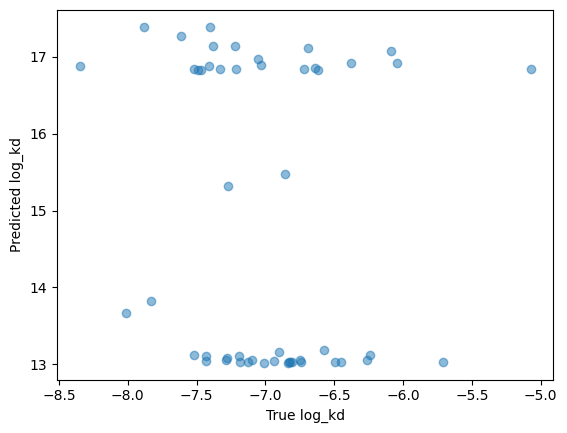

In [3]:
import matplotlib.pyplot as plt
df = pd.read_csv("/kaggle/working/test_predictions_AID1379.csv")
plt.scatter(df["targets"], df["predictions"], alpha=0.5)
plt.xlabel("True log_kd")
plt.ylabel("Predicted log_kd")
plt.savefig("/kaggle/working/scatter_AID1379.png")